In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Transaction data: cleaning and feature engineering

In [2]:
transaction = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='Transactions',skiprows=1)
transaction.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [3]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
transaction_id             20000 non-null int64
product_id                 20000 non-null int64
customer_id                20000 non-null int64
transaction_date           20000 non-null datetime64[ns]
online_order               19640 non-null float64
order_status               20000 non-null object
brand                      19803 non-null object
product_line               19803 non-null object
product_class              19803 non-null object
product_size               19803 non-null object
list_price                 20000 non-null float64
standard_cost              19803 non-null float64
product_first_sold_date    19803 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memory usage: 2.0+ MB


In [4]:
# Check null values  
transaction[transaction['brand'].isnull()][['brand','product_line','product_class','product_size','standard_cost','product_first_sold_date']]

,brand,product_line,product_class,product_size,standard_cost,product_first_sold_date
136,NaN,NaN,NaN,NaN,NaN,NaN
159,NaN,NaN,NaN,NaN,NaN,NaN
366,NaN,NaN,NaN,NaN,NaN,NaN
406,NaN,NaN,NaN,NaN,NaN,NaN
676,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
19340,NaN,NaN,NaN,NaN,NaN,NaN
19383,NaN,NaN,NaN,NaN,NaN,NaN
19793,NaN,NaN,NaN,NaN,NaN,NaN
19859,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Drop those with many missing values as its hard to fill nan values
transaction_dropna = transaction.dropna(how='any',axis=0)

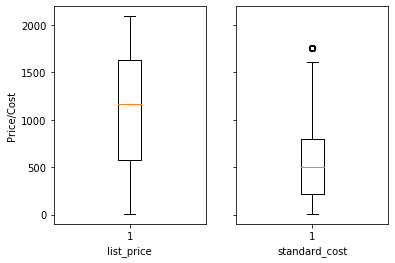

In [6]:
# Check outliers
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].boxplot(transaction_dropna['list_price'])
ax[0].set_xlabel('list_price')
ax[0].set_ylabel('Price/Cost')
ax[1].boxplot(transaction_dropna['standard_cost'])
ax[1].set_xlabel('standard_cost')
plt.show()

In [7]:
# Divide into 2 dataset for further analyse
transaction_approved = transaction_dropna[transaction_dropna['order_status'] == 'Approved']
transaction_declined = transaction_dropna[transaction_dropna['order_status'] != 'Approved']

In [8]:
# Frequency (F) in RFM model
# No. of purchase
purchase_approved_count = transaction_approved.groupby('customer_id')['transaction_id'].count()
purchase_approved_count.name = 'purchase_approved_count'
purchase_declined_count = transaction_declined.groupby('customer_id')['transaction_id'].count()
purchase_declined_count.name = 'purchase_declined_count'

In [9]:
# Recency (R) in RFM model
# Date of Recent purchase
recent_purchase_date = transaction_approved.groupby('customer_id')['transaction_date'].max()
least_recency = pd.Timestamp('2018-01-01 00:00:00') - recent_purchase_date
least_recency = least_recency.apply(lambda x:x.days)
least_recency.name = 'least_recency'

In [10]:
# Monetary Value(M) in RFM model
# Total Value(price&cost) of approved orders
price_sum = transaction_approved.groupby('customer_id')['list_price'].sum()
price_sum.name = 'price_sum'
cost_sum = transaction_approved.groupby('customer_id')['standard_cost'].count()
cost_sum.name = 'cost_sum'

In [11]:
# percentage of online order
online_order_percentage = transaction_approved.groupby('customer_id')['online_order'].sum()/purchase_approved_count
online_order_percentage.name = 'online_order_percentage'

Demograpic data: cleaning

In [12]:
demographic = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='CustomerDemographic',skiprows=1)
demographic.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0


In [13]:
demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
customer_id                            4000 non-null int64
first_name                             4000 non-null object
last_name                              3875 non-null object
gender                                 4000 non-null object
past_3_years_bike_related_purchases    4000 non-null int64
DOB                                    3913 non-null datetime64[ns]
job_title                              3494 non-null object
job_industry_category                  3344 non-null object
wealth_segment                         4000 non-null object
deceased_indicator                     4000 non-null object
default                                3698 non-null object
owns_car                               4000 non-null object
tenure                                 3913 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(9)
memory usage: 406.4+ KB


In [14]:
demographic_clean = demographic.copy()

In [15]:
demographic_clean.drop(columns='default',inplace=True)

In [16]:
# Fill missing test values
demographic_clean[['last_name','job_title','job_industry_category']] = demographic_clean[['last_name','job_title','job_industry_category']].fillna('Unknown')

In [17]:
# Use mean to fill nan tenuew
# Could be more precise
demographic_clean.tenure.fillna(demographic_clean.tenure.mean(),inplace=True)

In [18]:
demographic_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
customer_id                            4000 non-null int64
first_name                             4000 non-null object
last_name                              4000 non-null object
gender                                 4000 non-null object
past_3_years_bike_related_purchases    4000 non-null int64
DOB                                    3913 non-null datetime64[ns]
job_title                              4000 non-null object
job_industry_category                  4000 non-null object
wealth_segment                         4000 non-null object
deceased_indicator                     4000 non-null object
owns_car                               4000 non-null object
tenure                                 4000 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 375.1+ KB


In [19]:
# Extract year,month and day from DOB
demographic_clean['DOB_year'] = demographic_clean['DOB'].apply(lambda x:x.year)
demographic_clean['DOB_month'] = demographic_clean['DOB'].apply(lambda x:x.month)
demographic_clean['DOB_day'] = demographic_clean['DOB'].apply(lambda x:x.day)

C:\Users\Junbo\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Junbo\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\Junbo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Junbo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


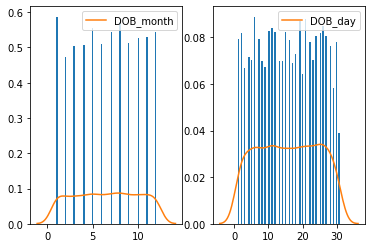

In [20]:
fig,ax = plt.subplots(1,2)
ax[0].hist(demographic_clean.DOB_month,bins=70,density=True)
sns.kdeplot(demographic_clean.DOB_month,ax=ax[0])
ax[1].hist(demographic_clean.DOB_day,bins=70,density=True)
sns.kdeplot(demographic_clean.DOB_day,ax=ax[1])
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1b47305d088>,
 'caps': [<matplotlib.lines.Line2D at 0x1b472291a88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b473076f08>],
 'medians': [<matplotlib.lines.Line2D at 0x1b472275088>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b472275888>],
 'means': []}

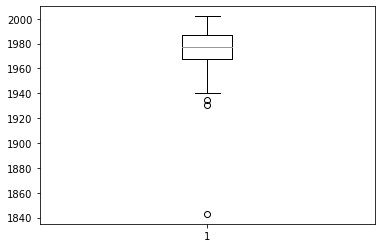

In [21]:
# Check outliers in year
plt.boxplot(demographic_clean.DOB_year.dropna())

In [22]:
# Clean outliers
demographic_clean = demographic_clean[demographic_clean['DOB_year']>1900]

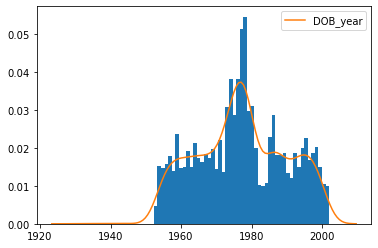

In [23]:
# Check the distribution of year 
plt.hist(demographic_clean.DOB_year,bins=70,density=True)
sns.kdeplot(demographic_clean.DOB_year)

In [24]:
demographic_clean['DOB_year'].fillna(demographic_clean['DOB_year'].median(),inplace=True) # Fill missing years
demographic_clean['age'] = 2018 - demographic_clean['DOB_year'] # Calculate age
demographic_clean['age_cut'],age_cut_boundary = pd.qcut(demographic_clean.age,5,labels=[1,2,3,4,5], retbins=True) # Divide into 5 grops based on quantile

In [25]:
age_cut_boundary

array([16., 29., 39., 44., 53., 87.])

In [26]:
# Check gender data
demographic_clean.gender.unique()

array(['F', 'Male', 'Female', 'Femal', 'M'], dtype=object)

In [27]:
def gender_clean(gender):
    if 'F' in gender: return 'Female'
    else: return 'Male'

demographic_clean.gender = demographic_clean.gender.apply(gender_clean)

{'whiskers': [<matplotlib.lines.Line2D at 0x1b47301eb48>,
 'caps': [<matplotlib.lines.Line2D at 0x1b473028688>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b47301e748>],
 'medians': [<matplotlib.lines.Line2D at 0x1b472fd3f48>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b471fc8488>],
 'means': []}

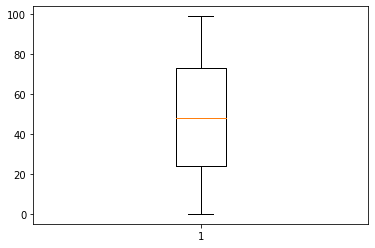

In [28]:
plt.boxplot(demographic_clean['past_3_years_bike_related_purchases'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1b472207d08>,
 'caps': [<matplotlib.lines.Line2D at 0x1b4721f9e88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b472207708>],
 'medians': [<matplotlib.lines.Line2D at 0x1b4728d26c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b4728d2f08>],
 'means': []}

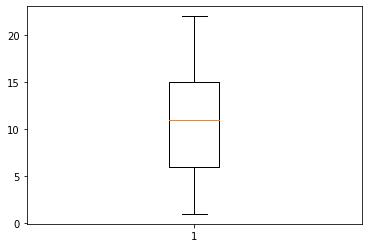

In [29]:
plt.boxplot(demographic_clean['tenure'])

'job_title' and 'job_industry_category' can be detailed cleaned
e.g. Using NLP to calculate the similarity between each record and combine similiar records, such as 'Programmer III' and 'Programmer II'

Address data :cleaning

In [30]:
address = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='CustomerAddress',skiprows=1)
address.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


In [31]:
address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
customer_id           3999 non-null int64
address               3999 non-null object
postcode              3999 non-null int64
state                 3999 non-null object
country               3999 non-null object
property_valuation    3999 non-null int64
dtypes: int64(3), object(3)
memory usage: 187.6+ KB


In [32]:
# Check state data
address.state.unique()

array(['New South Wales', 'QLD', 'VIC', 'NSW', 'Victoria'], dtype=object)

In [33]:
def state_clean(state):
    if 'V' in state: return 'VIC'
    elif 'N' in state: return 'NSW'
    else: return 'QLD'

address.state = address.state.apply(state_clean)

Could consider more economic factors based on the location

Combine all training data

In [34]:
train = demographic_clean.copy()
train = train.merge(purchase_approved_count, left_on='customer_id',right_index=True,how='left')
train = train.merge(purchase_declined_count, left_on='customer_id',right_index=True,how='left')
train = train.merge(least_recency, left_on='customer_id',right_index=True,how='left')
train = train.merge(price_sum, left_on='customer_id',right_index=True,how='left')
train = train.merge(cost_sum, left_on='customer_id',right_index=True,how='left')
train = train.merge(online_order_percentage, left_on='customer_id',right_index=True,how='left')
train = train.merge(address['state'], left_on='customer_id',right_index=True,how='left')
train = train.merge(address['property_valuation'], left_on='customer_id',right_index=True,how='left')

In [35]:
for column in train.columns:
    if type(train[column][0]) == str:
        train[column].fillna('Unknown',inplace=True)
    elif sum(train[column].isnull()) != 0: train[column].fillna(0,inplace=True)

In [36]:
train.drop(columns=['first_name','last_name','customer_id','DOB', 'DOB_year', 'DOB_month', 'DOB_day', 'age'], inplace = True)

Process test data

In [37]:
test = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name='NewCustomerList', skiprows=1)
test = test.drop(columns = ['Unnamed: 16','Unnamed: 17','Unnamed: 18','Unnamed: 19','Unnamed: 20','Rank', 'Value'])

In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
first_name                             1000 non-null object
last_name                              971 non-null object
gender                                 1000 non-null object
past_3_years_bike_related_purchases    1000 non-null int64
DOB                                    983 non-null datetime64[ns]
job_title                              894 non-null object
job_industry_category                  835 non-null object
wealth_segment                         1000 non-null object
deceased_indicator                     1000 non-null object
owns_car                               1000 non-null object
tenure                                 1000 non-null int64
address                                1000 non-null object
postcode                               1000 non-null int64
state                                  1000 non-null object
country                                1000 non-null 

In [39]:
test_clean = test.copy()

In [40]:
test_clean[['last_name','job_title','job_industry_category']] = test_clean[['last_name','job_title','job_industry_category']].fillna('Unknown')

In [41]:
test_clean.gender.unique()

array(['Male', 'Female', 'U'], dtype=object)

In [42]:
# Create a dictionary showing the most common sex in each job title
gender_fill = demographic_clean.groupby(['job_title','gender'])['DOB'].count().unstack().apply(lambda x: 'Female' if x[0] > x[1] else 'Male', axis=1).to_dict()

In [43]:
test_clean.loc[test_clean['gender'] == 'U','gender'] = test_clean[test_clean['gender'] == 'U']['job_title'].map(gender_fill)

{'whiskers': [<matplotlib.lines.Line2D at 0x1b47468ec88>,
 'caps': [<matplotlib.lines.Line2D at 0x1b474691788>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b4746ed288>],
 'medians': [<matplotlib.lines.Line2D at 0x1b4722d4f88>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b472156988>],
 'means': []}

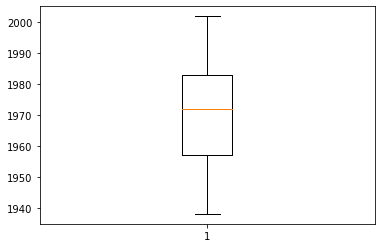

In [44]:
test_clean['DOB_year'] = test_clean['DOB'].apply(lambda x:x.year)
plt.boxplot(test_clean.DOB_year.dropna())

In [45]:
test_clean['DOB_year'].fillna(test_clean['DOB_year'].median(),inplace=True)
test_clean['age'] = 2018 - test_clean['DOB_year']
test_clean['age_cut'] = pd.cut(test_clean['age'],age_cut_boundary,labels=[1,2,3,4,5])

In [46]:
test_clean.drop(columns=['first_name','last_name','country','DOB','address','postcode', 'DOB_year', 'age'],inplace = True)

In [47]:
customer_attributes = test_clean.columns
transaction_features = train.columns.difference(customer_attributes)

In [48]:
text_features = []
for x in customer_attributes:
    if type(train[x][0]) == str:
        text_features.append(x)

        
text_features

['gender',
 'job_title',
 'job_industry_category',
 'wealth_segment',
 'deceased_indicator',
 'owns_car',
 'state']

In [49]:
dict_list = []
from sklearn.preprocessing import LabelEncoder
for feature in text_features:
    encoder = LabelEncoder().fit(train[feature])
    dict_list.append(dict(zip(encoder.classes_,encoder.transform(encoder.classes_))))
    train[feature] = encoder.transform(train[feature])
    test_clean[feature] = encoder.transform(test_clean[feature])

In [50]:
continuous_featuers = customer_attributes.difference(text_features)
continuous_featuers = continuous_featuers.drop('age_cut')

In [51]:
from sklearn.preprocessing import StandardScaler
for feature in continuous_featuers:
    scaler = StandardScaler().fit(np.array(train[feature]).reshape(-1, 1))
    train[feature] = scaler.transform(np.array(train[feature]).reshape(-1, 1))
    test_clean[feature] = scaler.transform(np.array(test_clean[feature]).reshape(-1, 1))
    print(feature, scaler.mean_, scaler.var_)
    
train[transaction_features] = StandardScaler().fit_transform(train[transaction_features])

past_3_years_bike_related_purchases [49.03936605] [827.39926831]
property_valuation [7.5140593] [7.99111113]
tenure [10.65465235] [32.01493746]


Model 1: identify high value customers through transaction data

In [52]:
transaction_features

Index(['cost_sum', 'least_recency', 'online_order_percentage', 'price_sum',
       'purchase_approved_count', 'purchase_declined_count'],
      dtype='object')

In [53]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(train[transaction_features])

In [54]:
kmeans.cluster_centers_

array([[-0.93796887,  0.15933191, -0.43180975, -0.90025803, -0.93796887,
        -0.07152849],
       [ 0.65808777, -0.11178877,  0.30296178,  0.63162949,  0.65808777,
         0.05018506]])

In [55]:
train['high_value'] = kmeans.labels_

In [56]:
if kmeans.cluster_centers_[0][0] > kmeans.cluster_centers_[1][0]: train['high_value'] = 1 - train['high_value']

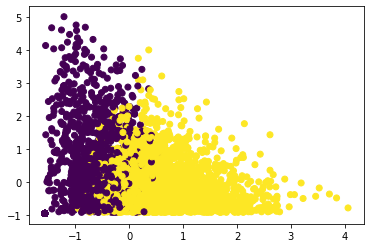

In [57]:
plt.scatter(train['price_sum'],train['least_recency'],c=kmeans.labels_)

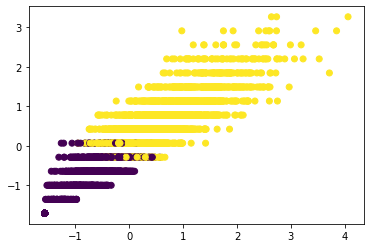

In [58]:
plt.scatter(train['price_sum'],train['purchase_approved_count'],c=kmeans.labels_)

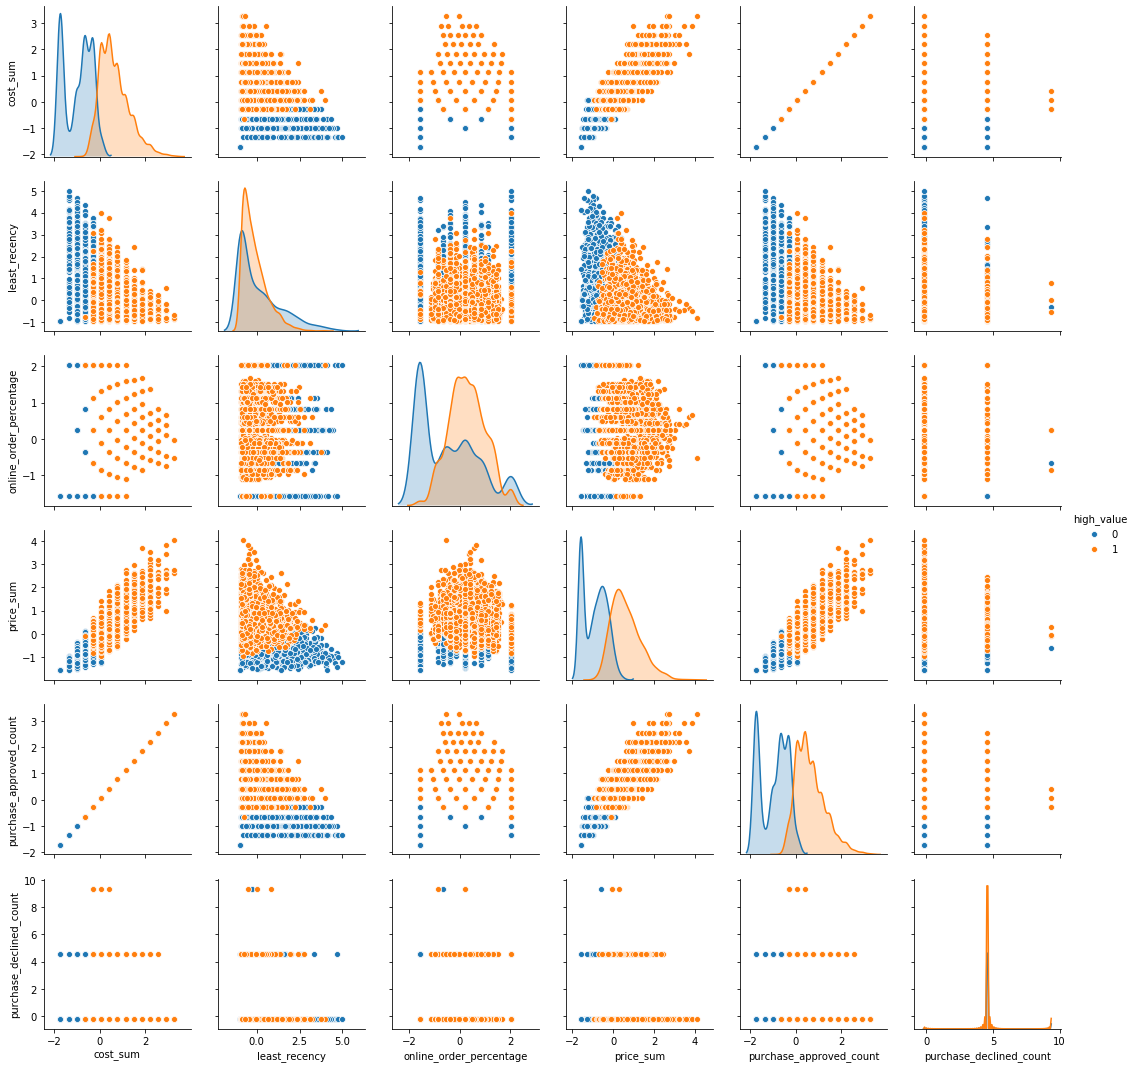

In [59]:
sns.pairplot(train,vars=transaction_features,hue='high_value')